# Text Classification

Now imagine that you are a data scientist who needs to build a system that can automatically
identify emotional states such as “anger” or “joy” that people express about
your company’s product on Twitter. In this chapter, we’ll tackle this task using a variant
of BERT called DistilBERT. The main advantage of this model is that it achieves
comparable performance to BERT, while being significantly smaller and more efficient.
This enables us to train a classifier in a few minutes.

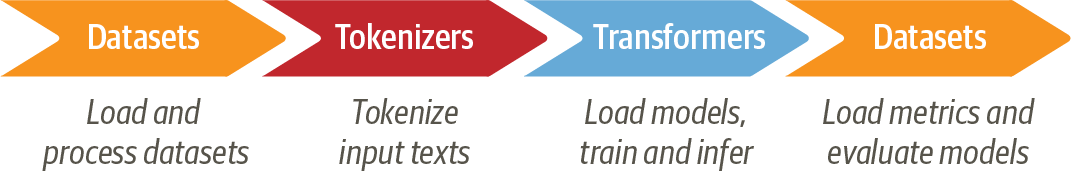

Figure 2-2. A typical pipeline for training transformer models with the Hugging Face Datasets, Tokenizers, and Transformers libraries

## Dataset

dataset contains
six basic emotions: anger, disgust, fear, joy, sadness, and surprise. Given a tweet,
our task will be to train a model that can classify it into one of these emotions.

### A First Look at Hugging Face Datasets

In [1]:
import datasets
print(datasets.__version__)

3.5.0


In [2]:
from datasets import load_dataset

emotions = load_dataset("emotion")

In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
len(train_ds)

16000

In [6]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
train_ds.column_names

['text', 'label']

In [8]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [9]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [10]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


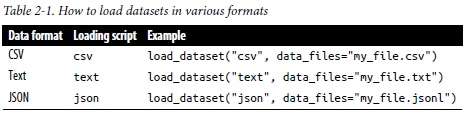

#### load url

```
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
!wget {dataset_url}

# peek at first row of train.txt
!head -n 1 train.txt

# load the file
emotions_local = load_dataset("csv", data_files="train.txt", sep=";",
                                names=["text", "label"])

# or mention URL itself
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";",
                                names=["text", "labels"])
```

### From Datasets to DataFrames

In [11]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


labels are represented as integers, use the int2str() method of the label feature to create a new column in our DataFrame with the corresponding label names:

In [12]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Look at the Class Distribution

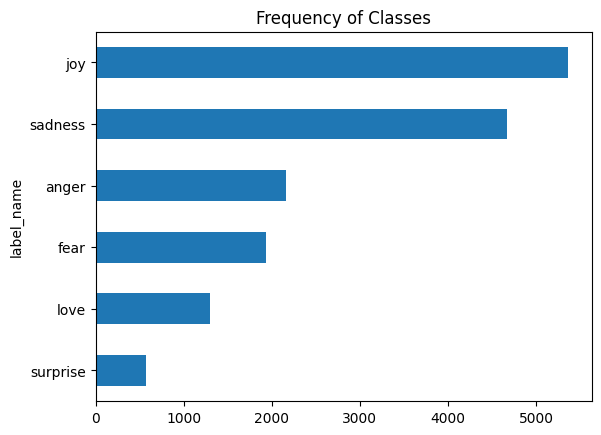

In [13]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In this case, we can see that the dataset is heavily imbalanced; the joy and sadness
classes appear frequently, whereas love and surprise are about 5–10 times rarer.
There are several ways to deal with imbalanced data, including:

- Randomly oversample the minority class.
- Randomly undersample the majority class.
- Gather more labeled data from the underrepresented classes.

- Imbalanced-learn library

### How Long are your Tweets?

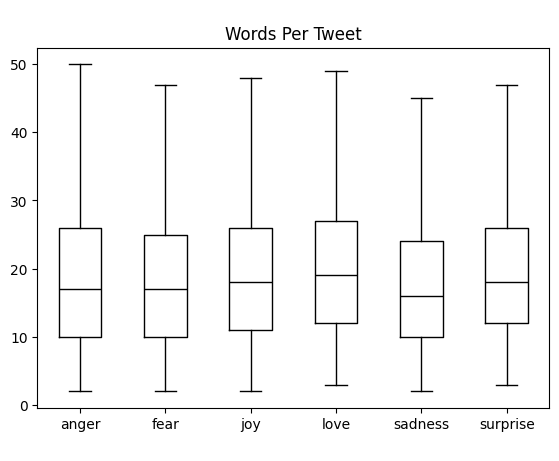

In [14]:
df['Words Per Tweet'] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
            showfliers=False, color="black")
plt.suptitle(" ")
plt.xlabel(" ")
plt.show()

From the plot we see that for each emotion, most tweets are around 15 words long
and the longest tweets are well below DistilBERT’s maximum context size. Texts that
are longer than a model’s context size need to be truncated, which can lead to a loss in
performance if the truncated text contains crucial information; in this case, it looks
like that won’t be an issue.

Let’s now figure out how we can convert these raw texts into a format suitable for
Transformers! While we’re at it, let’s also reset the output format of our dataset
since we don’t need the DataFrame format anymore:

In [15]:
emotions.reset_format()

## From Text to Tokens

### Character Tokenization

In [16]:
text = "Tokenizing text is a core task of NLP"
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P']


Our model expects each character to be converted to an integer, a process sometimes called numericalization. One simple way to do this is by encoding each unique token (which are characters in this case) with a unique integer:

In [17]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, 'L': 1, 'N': 2, 'P': 3, 'T': 4, 'a': 5, 'c': 6, 'e': 7, 'f': 8, 'g': 9, 'i': 10, 'k': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'x': 17, 'z': 18}


We can now use token2idx to transform the tokenized text to a list of integers:

In [18]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[4, 13, 11, 7, 12, 10, 18, 10, 12, 9, 0, 16, 7, 17, 16, 0, 10, 15, 0, 5, 0, 6, 13, 14, 7, 0, 16, 5, 15, 11, 0, 13, 8, 0, 2, 1, 3]


last step is to convert input_ids to a 2D tensor of one-hot vectors

In [19]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


We won't be using this, Not good for neural networks. In pandas, one-hot encoding can be implemented with get_dummies() function as follows:

In [20]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,False,True
2,False,True,False


We can create the one-hot encodings in PyTorch by converting input_ids to a tensor and applying the one_hot() function as follows:

In [21]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([37, 19])

For each of the 38 input tokens we now have a one-hot vector with 20 dimensions,
since our vocabulary consists of 20 unique characters.

WARN: It’s important to always set num_classes in the one_hot() function
because otherwise the one-hot vectors may end up being shorter
than the length of the vocabulary (and need to be padded with
zeros manually). In TensorFlow, the equivalent function is
tf.one_hot(), where the depth argument plays the role of
num_classes.

In [22]:
# first vector
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 4
One-hot: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


From our simple example we can see that character-level tokenization ignores any
structure in the text and treats the whole string as a stream of characters. Although
this helps deal with misspellings and rare words, the main drawback is that linguistic
structures such as words need to be learned from the data. This requires significant
compute, memory, and data. For this reason, character tokenization is rarely used in
practice. Instead, some structure of the text is preserved during the tokenization step.
Word tokenization is a straightforward approach to achieve this, so let’s take a look at
how it works.

### Word Tokenization

In [23]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP']


NOTE: Some word tokenizers have extra rules for punctuation. One can also apply stemming or lemmatization, which normalizes words to their stem (e.g. "great", "greater", "greatest" all become "great"), at the expense of losing some information in the text.

Having a large vocabulary is a problem because it requires neural networks to have an enormous number of parameters.

### Subword Tokenization

The basic idea behind subword tokenization is to combine the best aspects of character
and word tokenization. On the one hand, we want to split rare words into smaller
units to allow the model to deal with complex words and misspellings. On the other
hand, we want to keep frequent words as unique entities so that we can keep the
length of our inputs to a manageable size. The main distinguishing feature of
subword tokenization (as well as word tokenization) is that it is learned from the pretraining
corpus using a mix of statistical rules and algorithms.

In [24]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

The AutoTokenizer class belongs to a larger set of “auto” classes whose job is to automatically
retrieve the model’s configuration, pretrained weights, or vocabulary from
the name of the checkpoint. This allows you to quickly switch between models, but if
you wish to load the specific class manually you can do so as well. For example, we
could have loaded the DistilBERT tokenizer as follows:

In [25]:
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

lets see how tokenizer works:

In [26]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


We can see that the words have been mapped to unique integers in the input_ids field. attention_mask will be discussed later. Now that we have the input_ids field, we can convert them back into tokens using tokenizer's convert_ids_to_tokens() method:

In [27]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']


We can observe three things here. First, some special [CLS] and [SEP] tokens have
been added to the start and end of the sequence. These tokens differ from model to
model, but their main role is to indicate the start and end of a sequence. Second, the
tokens have each been lowercased, which is a feature of this particular checkpoint.
Finally, we can see that “tokenizing” and “NLP” have been split into two tokens,
which makes sense since they are not common words. The ## prefix in ##izing and
##p means that the preceding string is not whitespace; any token with this prefix
should be merged with the previous token when you convert the tokens back to a
string. 

The AutoTokenizer class has a convert_tokens_to_string() method for
doing just that, so let’s apply it to our tokens:

In [28]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp [SEP]


AutoTokenizer has several attributes, we can inspect the vocabulary size:

In [29]:
tokenizer.vocab_size

30522

and the corresponding model's maximum context size:

In [30]:
tokenizer.model_max_length

512

another attribute - name of the fields that the model expects in its forward_pass

In [31]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Now that we have a basic understanding of the tokenization process for a single string, let's see how we can tokenize the whole dataset!

WARN: When using pretrained models, it is really important to make sure that you use the same tokenizer that the model was trained with. From the model's perspective, switching the tokenizer is like shuffling the vocabulary. If everyone around you started swapping random words like "house" for "cat", you'd have a hard time understanding what was going on too!

## Tokenizing The Whole Dataset

In [32]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

This function applies the tokenizer to a batch of examples; `padding=True` will pad the examples with zeros to the size of the longest one in a batch, and `truncation=True` will truncate the examples to the model's maximum context size. 

In [33]:
# tokenize in action - batch of 2 examples
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Here we can see the result of padding: the first element of input_ids is shorter than the second, so zeros have been added to that element to make them the same length. These zeros have a corresponding [PAD] token in the vocabulary, and the set of special tokens also includes the [CLS] and [SEP] tokens that we encountered earlier:

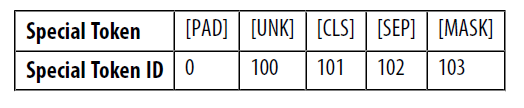

Also note that in addition to returning the encoded tweets as input_ids, the tokenizer returns a list of attention_mask arrays. This is because we do not want the model to get confused by the additional padding tokens: the attention mask allows the model to ignore the padded parts of the input. Figure 2-3 provides a visual explanation of how the input IDs and attention masks are padded.

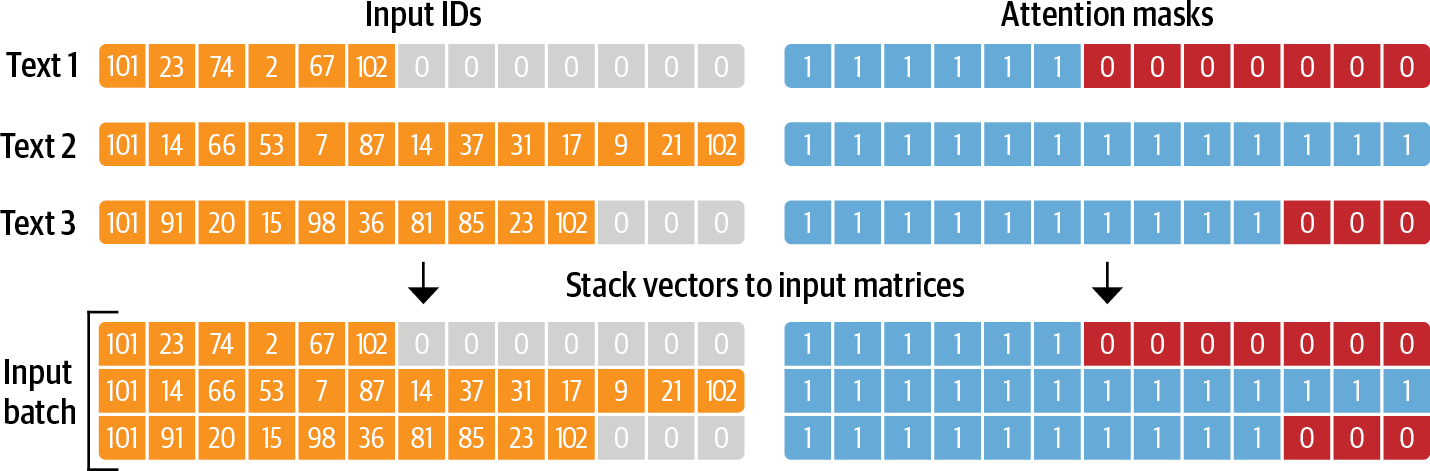

Figure 2-3. For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors.

Once we've defined a processing function, we can apply it across all the splits in the corpus in a single line of code:

In [34]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

By default, the map() method operates individually on every example in the corpus, so setting batched=True will encode the tweets in batches. Because we've set batch_size=True, our tokenize() function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see this operation has added new input_ids and attention_mask columns to the dataset:

In [35]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


NOTE: In later chapters, we'll see how data collators can be used to dynamically pad the tensors in each batch. Padding globally will come in handy in the next section, where we extract a feature matrix from the whole corpus.

## Training a Text Classifier

models like DistilBERT are pretrained to predict masked words in a sequence of text. However, we can't use these language models directly for text classification; we need to modify them slightly. To understand what modifications are necessary, let's take a look at the architecture of an encoder-based model like DistilBERT, which is depicted in Figure 2-4.

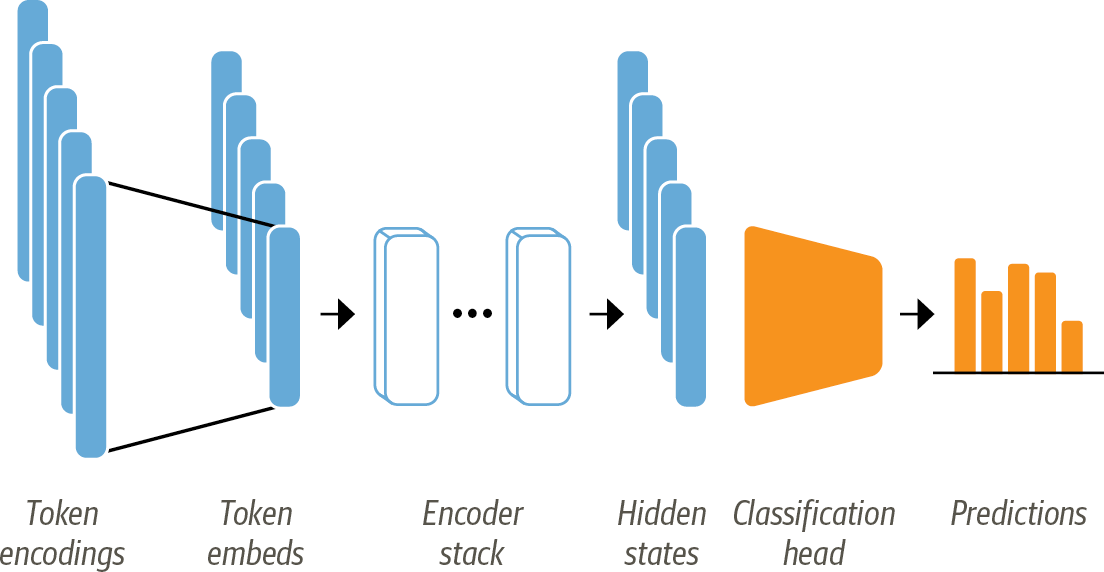

Figure 2-4. The architecture used for sequence classification with an encoder-based transformer; it consists of the model's pretrained body with a custom classification head

First the text is tokenized and represented as one-hot vectors called token encodings. The size of the tokenizer vocabulary determines the dimension of the token encodings, and it usually consists of 20k-200k unique tokens. Next, these token encodings are converted to token embeddings, which are vectors living in a lower-dimensional space. The token embeddings are then passed through the encoder block layers to yield a hidden state for each input token. For the pretraining objective of language modeling, each hidden state is fed to a layer that predicts the masked input tokens. For the classification task, we replace the language modeling layer with a classification layer.

NOTE: In practice, PyTorch skips the step of creating one-hot vectors for token encodings because multiplying a matrix with a one-hot vector is same as selecting a column from the matrix. This can be done directly by getting the column with the token ID from the matrix. We'll see this in Chapter 3 when we use the nn.Embedding class.

We have two options to train such a model on our Twitter dataset:

- Feature Extraction: We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.
- Fine-Tuning: We train the whole model end-to-end, which also updates the parameters of the pretrained model.

## Transformers as Feature Extractors

Using a transformer as a feature extractor is fairly simple. As shown in Figure 2-5, we freeze the body's weights during training and use the hidden states as features for the classifier. The advantage of this approach is that we can quickly train a small or shallow model. Such a model could be a neural classification layer or a method that does not rely on gradients, such as a random forest. This method is especially convenient if GPUs are unavailable, since the hidden states only need to be precomputed once.

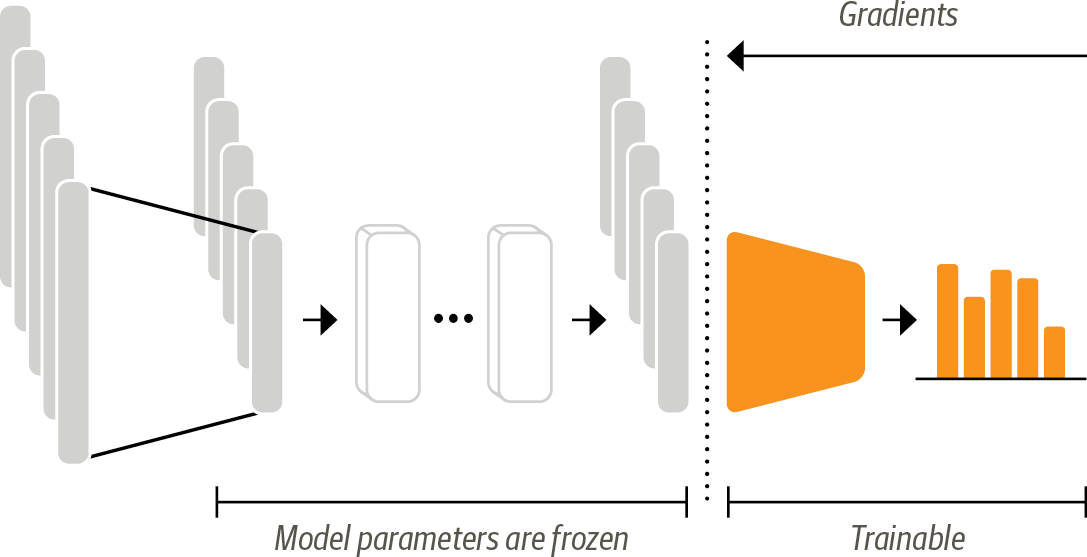

Figure 2-5. In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier

### Using pretrained models

We will use another convenient auto class from Transformers called AutoModel. Similar to the AutoTokenizer class, AutoModel has a from_pretrained() method to load the weights of a pretrained model. Let's use this method to load the DistilBERT checkpoint:

In [36]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Here we've used PyTorch to check whether a GPU is available or not, and then chained the PyTorch nn.Module.to() method to the model loader. This ensures that the model will run on the GPU if we have one. If not, the model will run on the CPU, which can be considerably slower.

The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. Let's take a look at how we can extract these states from our corpus.

### Extracting the last hidden states

To warm up, let's retrieve the last hidden states for a single string. The first thing we need to do is to encode the string and convert the tokens to PyTorch tensors. This can be done by providing the return_tensors="pt" argument to the tokenizer as follows:

In [37]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


As we can see, the resulting tensor has the shape [batch_size, n_tokens]. Now that we have the encodings as a tensor, the final step is to place them on the same device as the model and pass the inputs as follows:

In [38]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


Here we've used the torch.no_grad() context manager to disable the automatic calculation of the gradient. This is useful for inference since it reduces the memory footprint of the computations. Depending on the model configuration, the output can contain several objects, such as the hidden states, losses, or attentions, arranged in a class similar to a namedtuple in Python. In our example, the model output is an instance of BaseModelOutput, and we can simply access its attributes by name. The current model returns only one attribute, which is the last hidden state, so let's examine its shape:

In [39]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

Looking at the hidden state tensor, we see that it has the shape [batch_size, n_tokens, hidden_dim]. In other words, a 768-dimensional vector is returned for each of the 6 input tokens. For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into outputs.last_hidden_state as follows:

In [40]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Now we know how to get the last hidden state for a single string; let's do the same for the whole dataset by creating a new hidden_state column that stores all these vectors. As we did with tokenizer, we'll use the map() method of DatasetDict to extract all the hidden states in one go. The first thing we need to do is to wrap the previous steps in a processing function:

In [41]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

The only difference between this function and our previous logic is the final step where we place the final hidden state back on the CPU as a NumPy array. The map() method requires the processing function to return Python or NumPy objects when we're using batched inputs.

Since our model expects tensors as inputs, the next thing to do is convert the input_ids and attention_mask columns to the "torch" format, as follows:

In [42]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

We can go ahead and extract the hidden states across all splits in one go:

In [43]:
emotions_hidden = emotions_encoded.map(extract_hidden_states,batched=True)

Notice that we did not set batch_size=None in this case, which means the default batch_size=1000 is used instead. As expected, applying the extract_hidden_states() function has added a new hidden_state column to our dataset:

In [44]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

Now that we have the hidden states associated with each tweet, the next step is to train a classifier on them. To do that, we'll need a feature matrix-let's take a look.

### Creating a feature matrix

The preprocessed dataset now contains all the information we need to train a classifier on it. We will use the hidden states as input features and the labels as targets. We can easily create the corresponding arrays in the well-known Scikit-learn format as follows:

In [45]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

C:\Users\Pulkit Vyas\AppData\Local\Temp\ipykernel_9140\2887861572.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_train = np.array(emotions_hidden["train"]["hidden_state"])
C:\Users\Pulkit Vyas\AppData\Local\Temp\ipykernel_9140\2887861572.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
C:\Users\Pulkit Vyas\AppData\Local\Temp\ipykernel_9140\2887861572.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_train = np.array(emotions_hidden["train"]["label"])
C:\Users\Pulkit Vyas\AppData\Local\Temp\ipykernel_9140\2887861572.py:6: DeprecationWarning

((16000, 768), (2000, 768))

Before we train a model on the hidden states, it's good practice to perform a quick check to ensure that they provide a useful representation of the emotions we want to classify. In the next section, we'll see how visualizing the features provides a fast way to achieve this.

### Visualizing the training set

Since visualizing the hidden states in 768 dimensions is tricky to say the least, we'll use the powerful UMAP algorithm to project the vectors down to 2D. Since UMAP works the best when the features are scaled to lie in the [0,1] interval, we'll first apply a MinMaxScaler and then use the UMAP implementation from the umap-learn library to reduce the hidden states:

In [46]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

c:\Users\Pulkit Vyas\nlp_with_transformers\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,4.323485,5.970049,0
1,-3.116854,5.052616,0
2,5.283122,2.642737,3
3,-2.140275,2.952807,2
4,-3.308517,2.899867,3


The result is an array with the same number of training samples, but with only 2 features instead of the 768 we started with! Let's investigate the compressed data a little bit further and plot the density of points for each category separately:

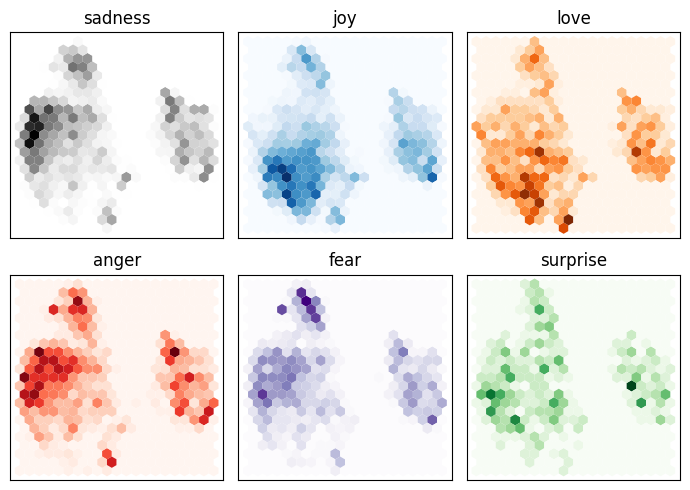

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

NOTE: These are only projections onto a lower-dimensional space. Just because some categories overlap does not mean that they are not separable in the original space. Conversely, if they are separable in the projected space they will be separable in the original space.

From this plot we can see some clear patterns: the negative feelings such as sadness, anger, and fear all occupy similar regions with slightly varying distributions. On the other hand, joy and love are well separated from the negative emotions and also share a similar space. Finally, suprise is scattered all over the place. Although we may not have hoped for some separation, this is in no way guaranteed since the model was not trained to know the difference between these emotions. It only learned them from implicitly by guessing the masked words in texts.

Now that we have gained some insight into the features of our dataset, let's finally train a model on it!

### Training a simple classifier

We've seen that the hidden states are somewhat different between the emotions, although for several of them there is no obvious boundary. Let's use these hidden states to train a logistic regression model with Scikit-Learn. Training such a simple model is fast and does not require a GPU:

In [48]:
from sklearn.linear_model import LogisticRegression

# We increase 'max_iter' to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6345

Looking at the accuracy, it might appear that our model is just a bit better than random- but since we are dealing with an unbalanced multiclass dataset, it's actually significantly better. We can examine whether our model is any good by comparing it against a simple baseline. In Scikit-learn there is a DummyClassifier that can be used to build a classifier with simple heuristics such as always choosing the majority class or always drawing a random class. In this case the best-performing heuristic is to always choose the most frequent class or always drawing a random class. In this case the best-performing heuristic is to always choose the most frequent class, which yields an accuracy of about 35%:

In [49]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

So, our simple classifier with DistilBERT embeddings is significantly better than our baseline. We can further investigate the performance of the model by looking at the confusion matrix of the classifier, which tells us the relationship between the true and predicted labels:

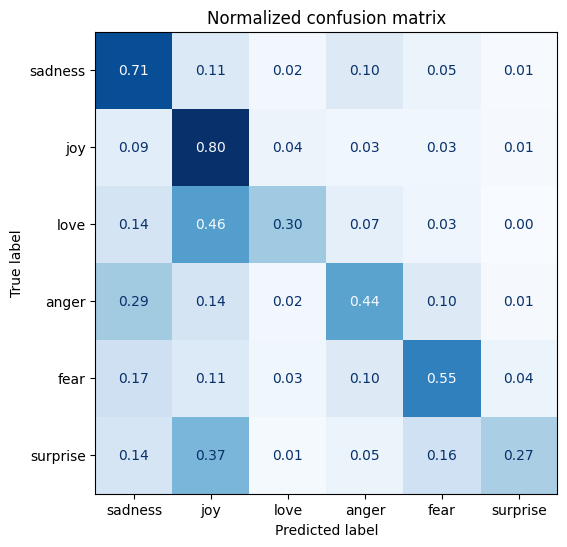

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

We can see that anger and fear are most often confused with sadness, which agrees with the observation we made when visualizing the embeddings. Also, love and suprise are frequently mistaken for joy.

In the next section we will explore the fine-tuning approach, which leads to superior classification performance. It is, however, important to note that doing this requires more computational resources, such as GPUs, that might not be available in your organization. In cases like these, a feature-based approach can be a good compromise between doing traditional machine learning and deep learning.

## Fine-Tuning Transformers

Let's now explore what it takes to fine-tune a transformer end-to-end. With the fine-tuning approach we do not use the hidden states as fixed features, but instead train them as shown in Figure 2-6. This requires the classification head to be differentiable, which is why this method usually uses a neural network for classification.

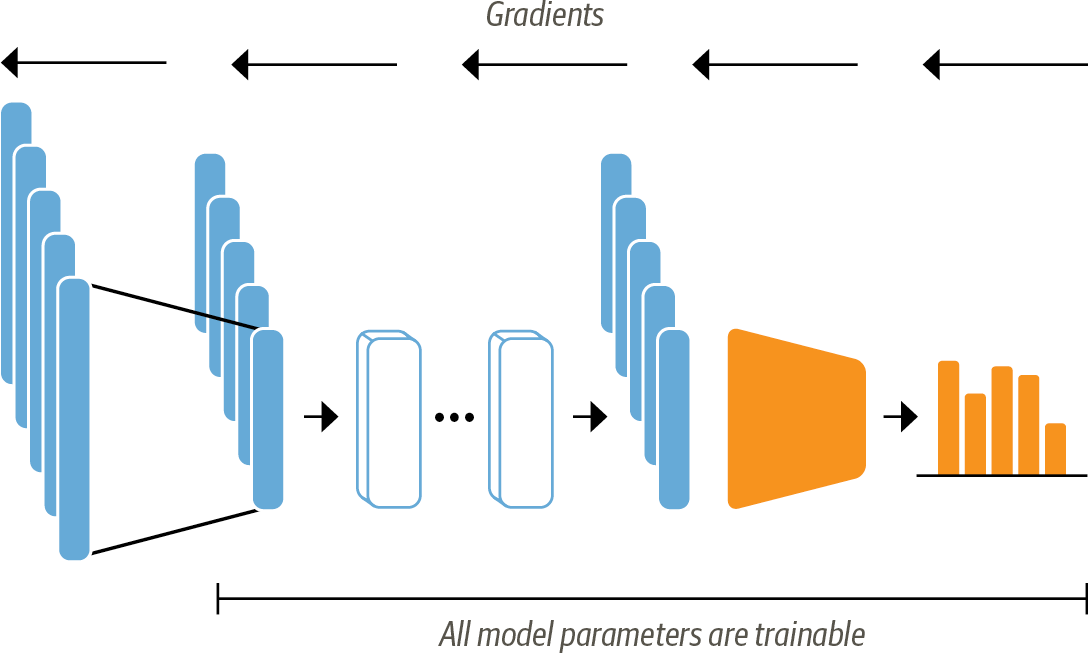

Figure 2-6. When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head

Training the hidden states that serve as inputs to the classification model will help us avoid the problem of working with data that may not be suited for the classification task. Instead, the initial hidden states adapt during training to decrease the model loss and thus increase its performance.

We'll be using the Trainer API from Transformers to simplify the training loop. Let's look at the ingredients we need to set one up!

### Loading a pretrained model

The first thing we need is pretrained DistilBERT model like the one we used in the feature-based approach. The only slight modification is that we use the AutoModelForSequenceClassification model instead of AutoModel. The difference is that the AutoModelForSequenceClassification model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:

In [51]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You will probably see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained. The next step is to define the metrics that we'll use to evaluate our model's performance during fine-tuning.

### Defining the performance metrics

To monitor metrics during training, we need to define a compute_metrics() function for the Trainer. This function receives an EvalPrediction object (which is a named tuple with predictions and label_ids attributes) and needs to return a dictionary that maps each metric's name to its value. For our application, we'll compute the $F_1$-score and the accuracy of the model as follows:

In [52]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

With the dataset and metrics ready, we just have two final things to take care of before we define the Trainer class:

1. Log in to our account on the Hugging Face Hub. This will allow us to push our fine-tuned model to our account on the Hub and share it with the community.

2. Define all the hyperparameters for the training run.

We'll tackle these steps in the next section.

### Training the model

If you're running this code in a Jupyter notebook, you can log in to the Hub with the following helper function:

In [53]:
from huggingface_hub import notebook_login

notebook_login()

This will display a widget in which you can enter your username and password, or an access token with write privileges. You can find details on how to create access tokens in the Hub documentation. If you're working in the terminal, you can log in by running the following command:

`huggingface-cli login`

To define the training parameters, we use the TrainingArguments class. This class stores a lot of information and gives you fine grained control over the training and evaluation. The most important argument to specify is output_dir, which is where all the artifacts from the training are stored. Here is an example of TrainingArguments in all its glory:

In [54]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

c:\Users\Pulkit Vyas\nlp_with_transformers\venv\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Here we also set the batch size, learning rate, and number of epochs, and specify to load the best model at the end of the training run. With this final ingredient, we can instantiate and fine-tune our model with the Trainer:

In [55]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

C:\Users\Pulkit Vyas\AppData\Local\Temp\ipykernel_9140\4051938262.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.820400,0.324289,0.908500,0.907707
2,0.252200,0.223447,0.925000,0.925004


Looking at the logs, we can see that our model has an $F_1$ score on the validations set of around $92%-$ this is significant improvement over the feature-based approach!

We can take a more detailed look at the training metrics by calculating the confusion matrix. To visualize the confusion matrix, we need to get the predictions on the validation set. The predict() method of the Trainer class returns several useful objects we can use for evaluation:

In [56]:
preds_output = trainer.predict(emotions_encoded["validation"])

The output of the predict() method is a PredictionOutput object that contains array of predictions and label_ids, along with the metrics we passed to the trainer. For example, the metrics on the validation set can be accessed as follows:

In [57]:
preds_output.metrics

{'test_loss': 0.22344732284545898,
 'test_accuracy': 0.925,
 'test_f1': 0.92500419346515,
 'test_runtime': 9.0914,
 'test_samples_per_second': 219.987,
 'test_steps_per_second': 3.52}

It also contains the raw predictions for each class. We can decode the predictions greedily using np.argmax(). This yields the predicted labels and has the same format as the labels returned by the Scikit-learn models in the feature-based approach:

In [58]:
y_preds = np.argmax(preds_output.predictions, axis=1)

With the predictions, we can plot the confusion matrix again:

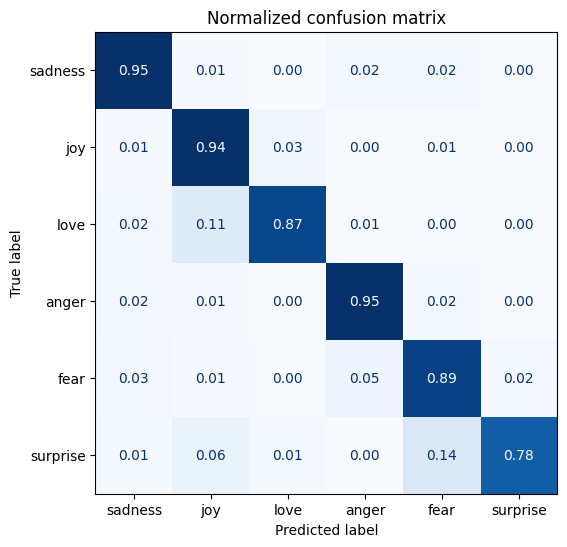

In [59]:
plot_confusion_matrix(y_preds, y_valid, labels)

This is much closer to the ideal diagonal confusion matrix. The love category is still often confused with joy, which seems natural. surprise is also frequently mistaken for joy, or confused with fear. Overall the performance of the model seems quite good, but before we call it a day, let's dive a little deeper into the types of errors our model is likely to make.

### Error analysis

Before moving on, we should investigate our model's predictions a little bit further. A simple yet powerful technique is to sort the validation samples by the model loss. When we pass the label during the forward pass, the loss is automatically calculated and returned. Here's a function that returns the loss along with the predicted label:

In [61]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                         reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
        "predicted_label": pred_label.cpu().numpy()}

Using the map() method once more, we can apply this function to get the losses for all the samples:

In [62]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Finally, we create a DataFrame with the texts, losses, and predicted/true labels:

In [63]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

We can now easily sort emotions_encoded by the losses in either ascending or descending order. The goal of this exercise is to detect one of the following:

Wrong labels: Every process that adds labels to data can be flawed. Annotators can make mistakes or disagree, while labels that are inferred from other features can be wrong. If it was easy to automatically annotate data, then we would not need a model to do it. Thus, it is normal that there are some wrongly labeled examples. With this approach, we can quickly find and correct them.

Quirks of the dataset: Datasets in the real world are always a bit messy. When working with text, special characters or strings in the inputs can have big impact on the model's predictions. Inspecting the model's weakest predictions can help identify such features, and cleaning the data or injecting similar examples can make the model more robust.

Let's first have a look at the data samples with the highest losses:

In [66]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1274,i am going to several holiday parties and i ca...,joy,sadness,5.699656
765,i feel super awkward and out of place right now,joy,sadness,5.467000
1963,i called myself pro life and voted for perry w...,joy,sadness,5.454207
465,i would eventually go in to these stores but i...,joy,fear,5.413610
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.327422
1111,im lazy my characters fall into categories of ...,joy,fear,5.177960
1509,i guess this is a memoir so it feels like that...,joy,fear,5.043513
1950,i as representative of everything thats wrong ...,surprise,sadness,4.976336
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.751781
882,i feel badly about reneging on my commitment t...,love,sadness,4.727315


We can clearly see that the model predicted some of the labels incorrectly. On the
other hand, it seems that there are quite a few examples with no clear class, which
might be either mislabeled or require a new class altogether. In particular, joy seems
to be mislabeled several times. With this information we can refine the dataset, which
often can lead to as big a performance gain (or more) as having more data or larger
models!

When looking at the samples with the lowest losses, we observe that the model seems
to be most confident when predicting the sadness class. Deep learning models are
exceptionally good at finding and exploiting shortcuts to get to a prediction. For this
reason, it is also worth investing time into looking at the examples that the model is
most confident about, so that we can be confident that the model does not improperly
exploit certain features of the text. So, let’s also look at the predictions with the
smallest loss:

In [67]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1310,i feel like an ungrateful asshole,sadness,sadness,0.017608
632,i feel he is an terrific really worth bet,joy,joy,0.017623
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.017732
1528,i am feeling a little happy with him,joy,joy,0.017859
1873,i feel practically virtuous this month i have ...,joy,joy,0.017889
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.017929
604,i don t like to use the h word recklessly but ...,joy,joy,0.017933
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.018036
19,i had lunch with an old friend and it was nice...,joy,joy,0.018097
11,i was dribbling on mums coffee table looking o...,joy,joy,0.018116


We now know that the joy is sometimes mislabeled and that the model is most confident
about predicting the label sadness. With this information we can make targeted
improvements to our dataset, and also keep an eye on the class the model seems to be
very confident about.

The last step before serving the trained model is to save it for later usage. Transformers
allows us to do this in a few steps, which we’ll show you in the next section.

### Saving and sharing the model

The NLP community benefits greatly from sharing pretrained and fine-tuned models, and everybody can share their models with others via the Hugging Face Hub. Any
community-generated model can be downloaded from the Hub just like we downloaded
the DistilBERT model. With the Trainer API, saving and sharing a model is
simple:

In [68]:
trainer.push_to_hub(commit_message="Training completed!")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/praffulvyas/distilbert-base-uncased-finetuned-emotion/commit/3c35c95d0b9fdc20b87606c75c2e6d71bdb4d1d4', commit_message='Training completed!', commit_description='', oid='3c35c95d0b9fdc20b87606c75c2e6d71bdb4d1d4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/praffulvyas/distilbert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='praffulvyas/distilbert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)

We can also use the fine-tuned model to make predictions on new tweets. Since we've pushed our model to the Hub, we can now use it with the pipeline() function, just like we did in Chapter 1. First let's load the pipeline:

In [69]:
from transformers import pipeline

model_id = "praffulvyas/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

Then let's test the pipeline with a sample tweet:

In [70]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

c:\Users\Pulkit Vyas\nlp_with_transformers\venv\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Finally, we can plot the probability for each class in a bar plot. Clearly, the model estimates that the most likely class is joy, which appears to be reasonable given the tweet:

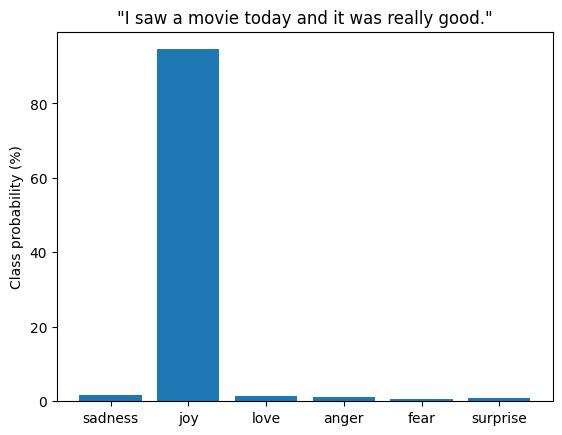

In [71]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

## Conclusion

Congratulations, you now know how to train a transformer model to classify the
emotions in tweets! We have seen two complementary approaches based on features
and fine-tuning, and investigated their strengths and weaknesses.

However, this is just the first step in building a real-world application with transformer
models, and we have a lot more ground to cover. Here’s a list of challenges
you’re likely to experience in your NLP journey:

My boss wants my model in production yesterday!
In most applications, your model doesn’t just sit somewhere gathering dust—you
want to make sure it’s serving predictions! When a model is pushed to the Hub,
an inference endpoint is automatically created that can be called with HTTP
requests. We recommend checking out the documentation of the Inference API if
you want to learn more.

My users want faster predictions!
We’ve already seen one approach to this problem: using DistilBERT. In Chapter 8
we’ll dive into knowledge distillation (the process by which DistilBERT was created),
along with other tricks to speed up your transformer models.

Can your model also do X?
As we’ve alluded to in this chapter, transformers are extremely versatile. In the
rest of the book we will be exploring a range of tasks, like question answering and
named entity recognition, all using the same basic architecture.

None of my texts are in English!
It turns out that transformers also come in a multilingual variety, and we’ll use
them in Chapter 4 to tackle several languages at once.

I don’t have any labels!
If there is very little labeled data available, fine-tuning may not be an option. In
Chapter 9, we’ll explore some techniques to deal with this situation.

Now that we’ve seen what’s involved in training and sharing a transformer, in the next
chapter we’ll explore implementing our very own transformer model from scratch.